# Goldbach's comet

## Goldbach's comet with Numba and Datashader

This Python notebook is about computing and plotting the Goldbach function. It requires some basic mathematical knowledge, but no fancy fancy prime number theory! The main point is to perfom some computations with [Numba](http://numba.pydata.org/) and some efficient plotting with [Datashader](https://datashader.org/).

Here is the definition of the Goldbach function from [Wikipedia](https://en.wikipedia.org/wiki/Goldbach%27s_comet):

> The function $g ( E )$  is defined for all even integers $E > 2$ to be the number of different ways in which E can be expressed as the sum of two primes. For example, $g ( 22 ) = 3$  since 22 can be expressed as the sum of two primes in three different ways ( 22 = 11 + 11 = 5 + 17 = 3 + 19).

The different prime pairs $(p_1, p_2)$ that sum to an even integer $E=p_1+p_2$ are called Goldbach partitions. So $g(E)$ is the count of distinct Goldbach partitions of $E$, without regard to the order of the primes in the pairs.

Note that for Goldbach's conjecture to be false, there must be $g(E) = 0$ somewhere for $E > 2$. This is very unlikely to occur, but has not been proved yet. Anyway, here are the steps used in this notebook to compute Goldbach function. Given a positive integer $n$:
- For each natural number $k \leq n$, build a quick way to check if $k$ is a prime or not, and list all the primes smaller or equal to $n$, using a sieve method.
- For each even number $E \leq n$, compute $g(E)$ by counting the number of cases where $E-p$ is prime for all primes $p$ not larger than $E/2$. 

## Imports

In [1]:
from typing import Tuple

from colorcet import palette
import datashader as ds
from datashader.mpl_ext import dsshow
import matplotlib.pyplot as plt
from numba import jit, njit, prange
import numpy as np
import pandas as pd
from sympy import sieve

plt.style.use("seaborn")

FS = (20, 10)  # figure size

## Prime number sieve

The `generate_primes` function creates a list of primes smaller or equal to $n$ and a boolean vector `is_prime_vec` of size $n+1$: `is_prime_vec[k]` is `True` if `k` is a prime.

In [2]:
def generate_primes(n: int) -> Tuple[np.ndarray, np.ndarray]:

    primes = np.array([i for i in sieve.primerange(n)])
    is_prime_vec = np.zeros(n + 1, dtype=np.bool_)
    is_prime_vec[primes] = True

    return primes, is_prime_vec


n = 11
primes, is_prime_vec = generate_primes(n)
print(f"primes = {primes}")
print(f"is_prime_vec = {is_prime_vec}")

primes = [2 3 5 7]
is_prime_vec = [False False  True  True False  True False  True False False False False]


## Evaluate Goldbach function for a given even number

Now we show how $g(E)$ can be computed for a given value of $E$ with Numba. In the `compute_g` function, we loop over all primes $p \leq E/2 $ with a `for` loop : if $E-p$ is a prime, $(p, E-P)$ is a partition of $E$. By looping over all primes $p \leq E/2$, we count all the possible partitions of $E$. The upper bound of the `for` loop is computed using `np.searchsorted`, since primes are sorted within the `primes` array. This returns the index of the largest prime in the array smaller or equal to $E/2$.

In [3]:
@jit(nopython=True)
def compute_g(is_prime_vec: np.ndarray, primes: np.ndarray, E: int) -> int:

    assert E < len(is_prime_vec)
    assert E % 2 == 0
    E_half = int(0.5 * E)

    # initialization
    count = 0  # number of prime pairs

    # we loop over all the prime numbers smaller than or equal to half of E
    i_max = np.searchsorted(primes, E_half, side="right")
    for i in range(i_max):
        if is_prime_vec[E - primes[i]]:
            count += 1

    return count

We check the function for a few values of $E$:

In [4]:
E = 22
primes, is_prime_vec = generate_primes(E)
g = compute_g(is_prime_vec, primes, E)
assert g == 3

E = 1890  # https://www.ias.ac.in/article/fulltext/reso/019/11/1028-1037
primes, is_prime_vec = generate_primes(E)
g = compute_g(is_prime_vec, primes, E)
assert g == 91

E = 1_000_000  # https://resources.wolframcloud.com/FunctionRepository/resources/Goldbach/
primes, is_prime_vec = generate_primes(E)
g = compute_g(is_prime_vec, primes, E)
assert g == 5402

## Evaluate Goldbach function over a range of even numbers

Now we are going to loop over all even values $E \leq n$ to compute all the corresponding values of $g$. Note that in the following `compute_g_vector` function, the outer loop has a constant step size of 1, in order to use Numba `prange`, which only supports this unit step size. This means that we loop on contiguous $E/2$ integer values instead of even $E$ values. Also, we compute `is_prime_vec` and `primes` only once and use it for all the evaluations of $g$.

`n` is calculted from the length of `is_prime_vec`. In the arguments, we assume that `primes` is corresponding to the primes of `is_prime_vec`.

In [5]:
@njit(parallel=True)
def compute_g_vector(is_prime_vec: np.ndarray, primes: np.ndarray) -> np.ndarray:

    n_max = len(is_prime_vec) - 1
    n_max_half = int(0.5 * n_max) + 1

    g_vec = np.empty(n_max_half, dtype=np.uint)

    for E_half in prange(n_max_half):
        count = 0
        E = 2 * E_half
        i_max = np.searchsorted(primes, E_half, side="right")
        for i in range(i_max):
            if is_prime_vec[E - primes[i]]:
                count += 1

        g_vec[E_half] = np.uint(count)

    return g_vec


n = 10
primes, is_prime_vec = generate_primes(n)
g_vec = compute_g_vector(is_prime_vec, primes)
g_vec

array([0, 0, 1, 1, 1, 2], dtype=uint64)

The $i$-th value of `g_vec` correponds to $g(2 \, i)$ with $i \geq 0 $:


| i |  E  | g_vec |
|--:|----:|---------:|
| 0 |  0  |        0 |
| 1 |  2  |        0 |
| 2 |  4  |        1 |
| 3 |  6  |        1 |
| 4 |  8  |        1 |
| 5 | 10  |        2 |

We can check $g$ at least for some for some small values of $E$ :

In [6]:
n = 56
primes, is_prime_vec = generate_primes(n)
g_vec = compute_g_vector(is_prime_vec, primes)
g_vec_ref = [0, 0, 1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 4, 4, 2, 3, 4, 
    3, 4, 5, 4, 3, 5, 3]
np.testing.assert_array_equal(g_vec, g_vec_ref)

Finally we wrap everything into a function that also loads the values of `g_vec` into a Pandas dataframe for convenience:

In [7]:
def compute_g_df(n):
    primes, is_prime_vec = generate_primes(n)
    g_vec = compute_g_vector(is_prime_vec, primes)
    g_df = pd.DataFrame(data={"E": 2 * np.arange(len(g_vec)), "g": g_vec})
    g_df = g_df[g_df.E > 2]  # The function g(E) is defined for all even integers E>2
    return g_df


compute_g_df(11)

,E,g
2,4,1
3,6,1
4,8,1
5,10,2


## First plot of the comet

We start by computing the Goldbach function up to $E=10000$ : 

In [8]:
%%time
n = 20_000
g_df_small = compute_g_df(n)

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 9.37 ms


In [9]:
len(g_df_small)

9999

And plot it with Matplotlib:

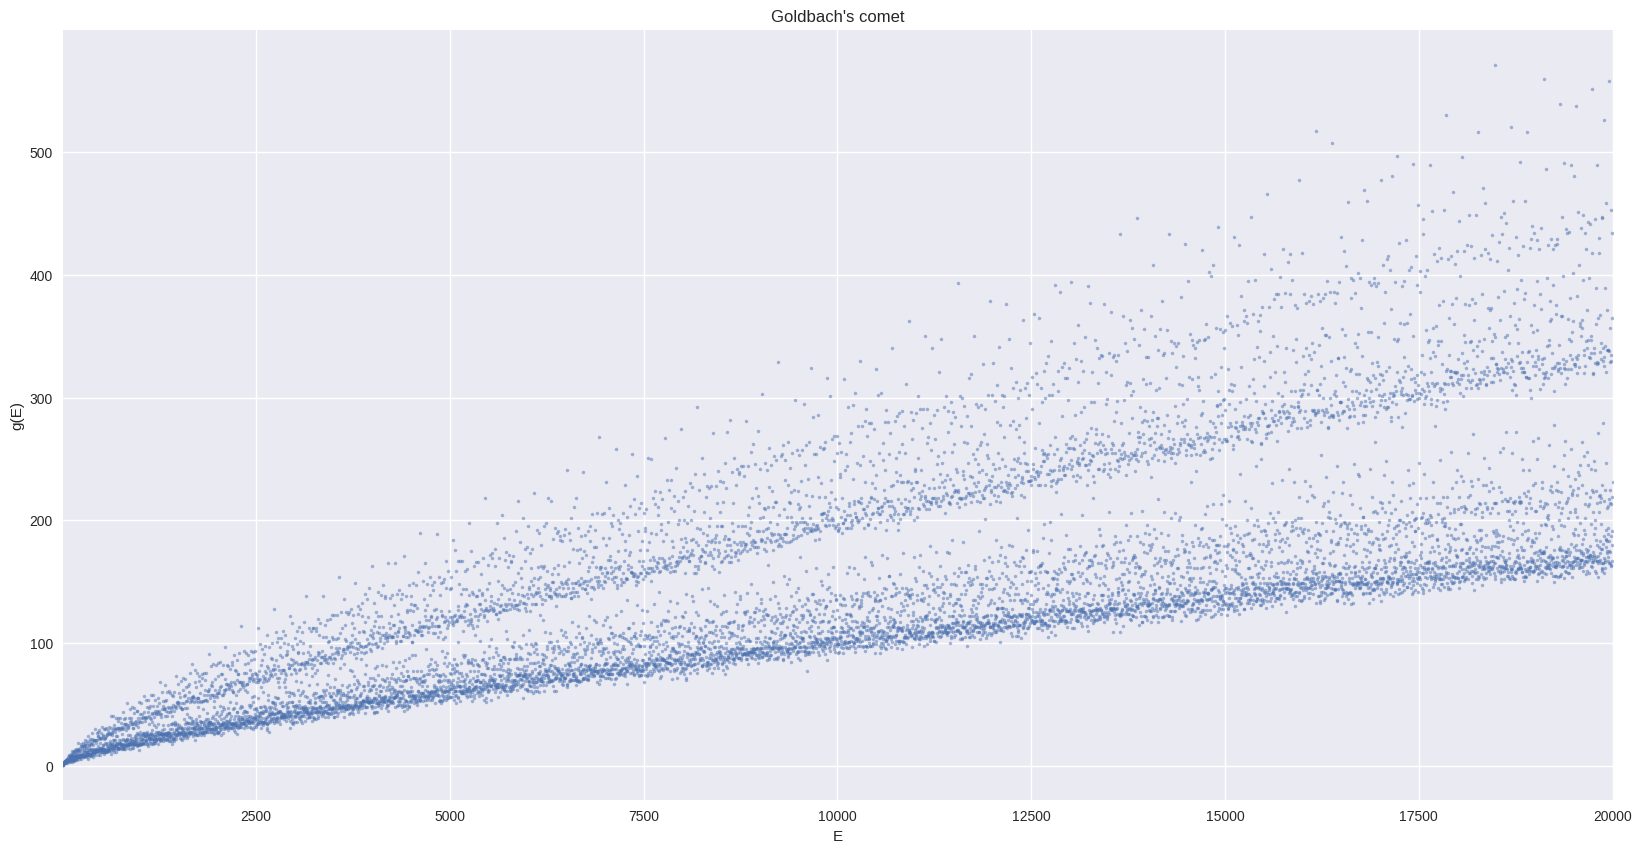

In [10]:
ax = g_df_small.plot(x="E", y="g", style=".", ms=5, alpha=0.5, legend=False, figsize=FS)
_ = ax.set(
    title="Goldbach's comet",
    xlabel="E",
    ylabel="g(E)",
)
ax.autoscale(enable=True, axis="x", tight=True)
ax.grid(True)

## Plot the comet with Datashader

Now let's compute the Goldbach function with a larger value of $n$ (this takes about 25 - 30s on my laptop, Intel(R) i7-7700HQ CPU @ 2.80GHz with 8 cores): 

In [11]:
%%time
n = 2_000_000
g_df = compute_g_df(n)

CPU times: user 1min, sys: 60.2 ms, total: 1min
Wall time: 44.9 s


In [12]:
len(g_df)

999999

The plot is made using Datashader's interface for Matplotlib.

In [13]:
cmap = palette["dimgray"][::-1]
bg_col = "white"

CPU times: user 585 ms, sys: 0 ns, total: 585 ms
Wall time: 585 ms


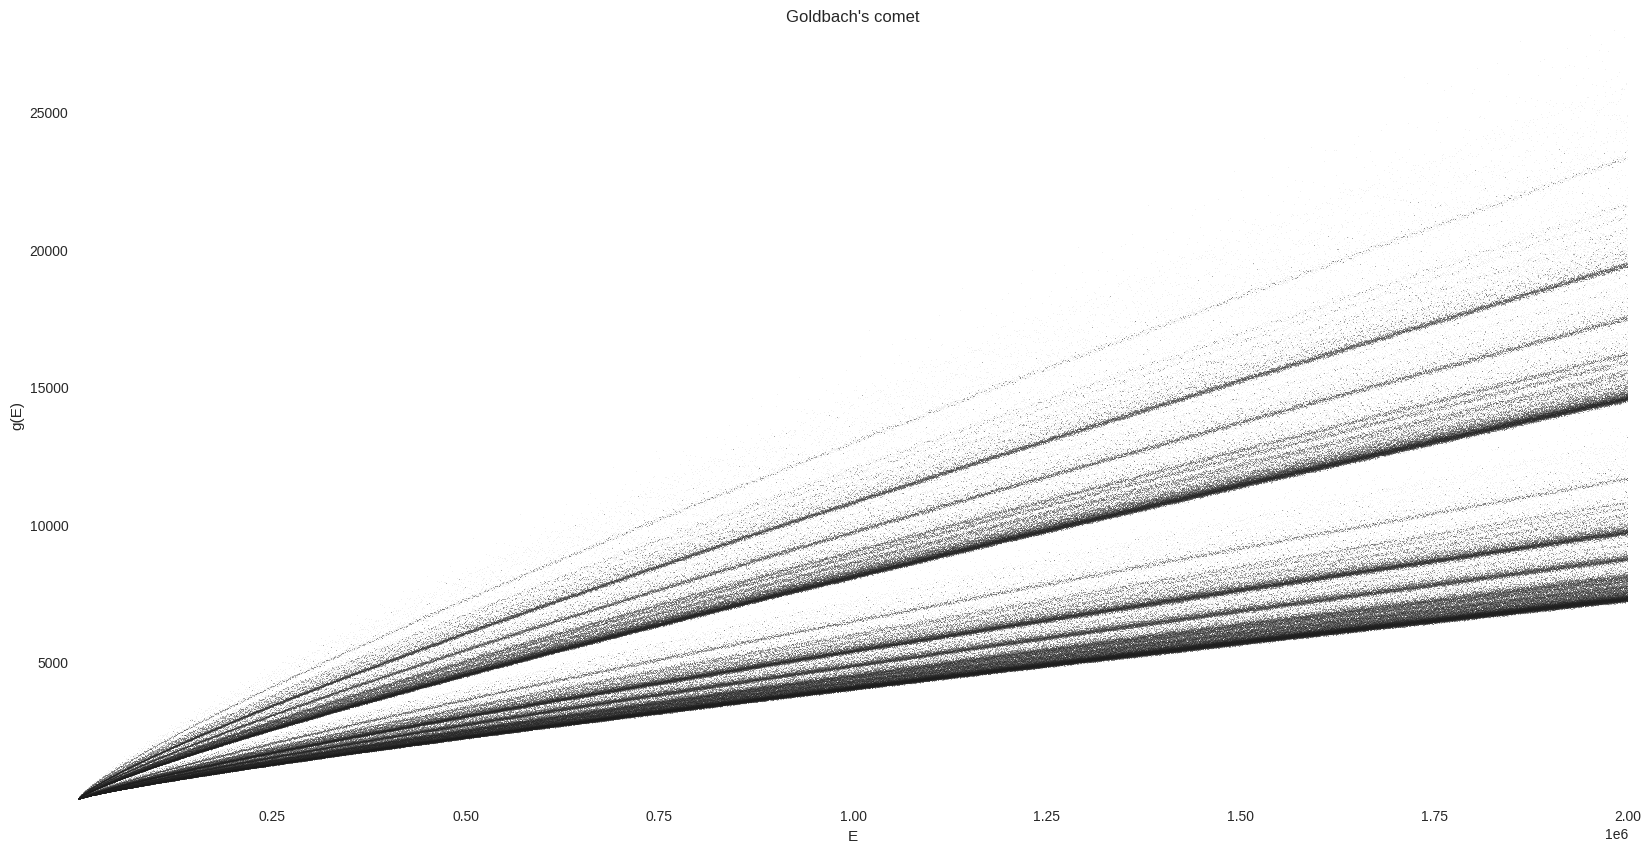

In [14]:
%%time
fig, ax = plt.subplots(figsize=FS)
_ = dsshow(
    g_df,
    ds.Point("E", "g"),
    norm="eq_hist",
    cmap=cmap,
    aspect="auto",
    ax=ax,
)
ax.grid(False)
ax.set_facecolor(bg_col)
_ = ax.set(title="Goldbach's comet", xlabel="E", ylabel="g(E)")

We can clearly observe some dense lines in this "comet tail". In order to visualize this vertical distribution of prime pairs count, we are are going to normalize $g$. As explained on [wikipedia](https://en.wikipedia.org/wiki/Goldbach%27s_comet):

> An illuminating way of presenting the comet data is as a histogram. The function $g(E)$ can be normalized by dividing by the locally averaged value of $g$, $g_{av}$, taken over perhaps 1000 neighboring values of the even number $E$. The histogram can then be accumulated over a range of up to about 10% either side of a central $E$. 

In [15]:
%%time
g_df["g_av"] = g_df["g"].rolling(window=1000, center=True).mean()
g_df["g_norm"] = g_df["g"] / g_df["g_av"]

CPU times: user 29 ms, sys: 3.99 ms, total: 33 ms
Wall time: 32.3 ms


CPU times: user 308 ms, sys: 36 ms, total: 344 ms
Wall time: 344 ms


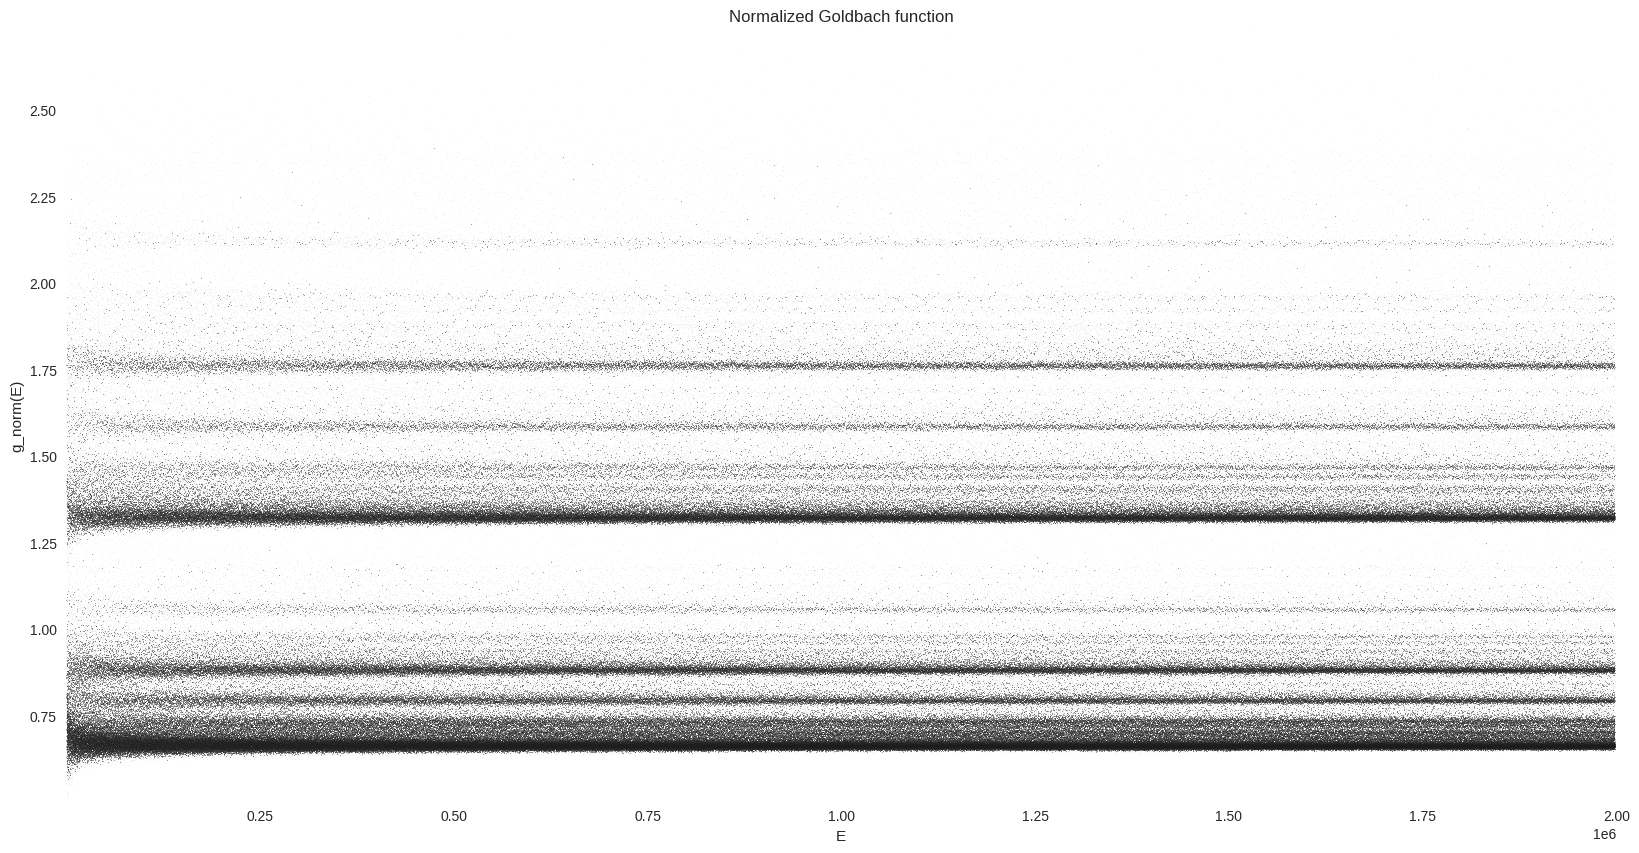

In [16]:
%%time
fig, ax = plt.subplots(figsize=FS)
_ = dsshow(
    g_df,
    ds.Point("E", "g_norm"),
    norm="eq_hist",
    cmap=cmap,
    aspect="auto",
    ax=ax,
)
ax.grid(False)
ax.set_facecolor(bg_col)
_ = ax.set(title="Normalized Goldbach function", xlabel="E", ylabel="g_norm(E)")

We can also plot the histogram of the comet data, which will lead to some kind of cross section of the above plot:

CPU times: user 618 ms, sys: 8.01 ms, total: 626 ms
Wall time: 626 ms


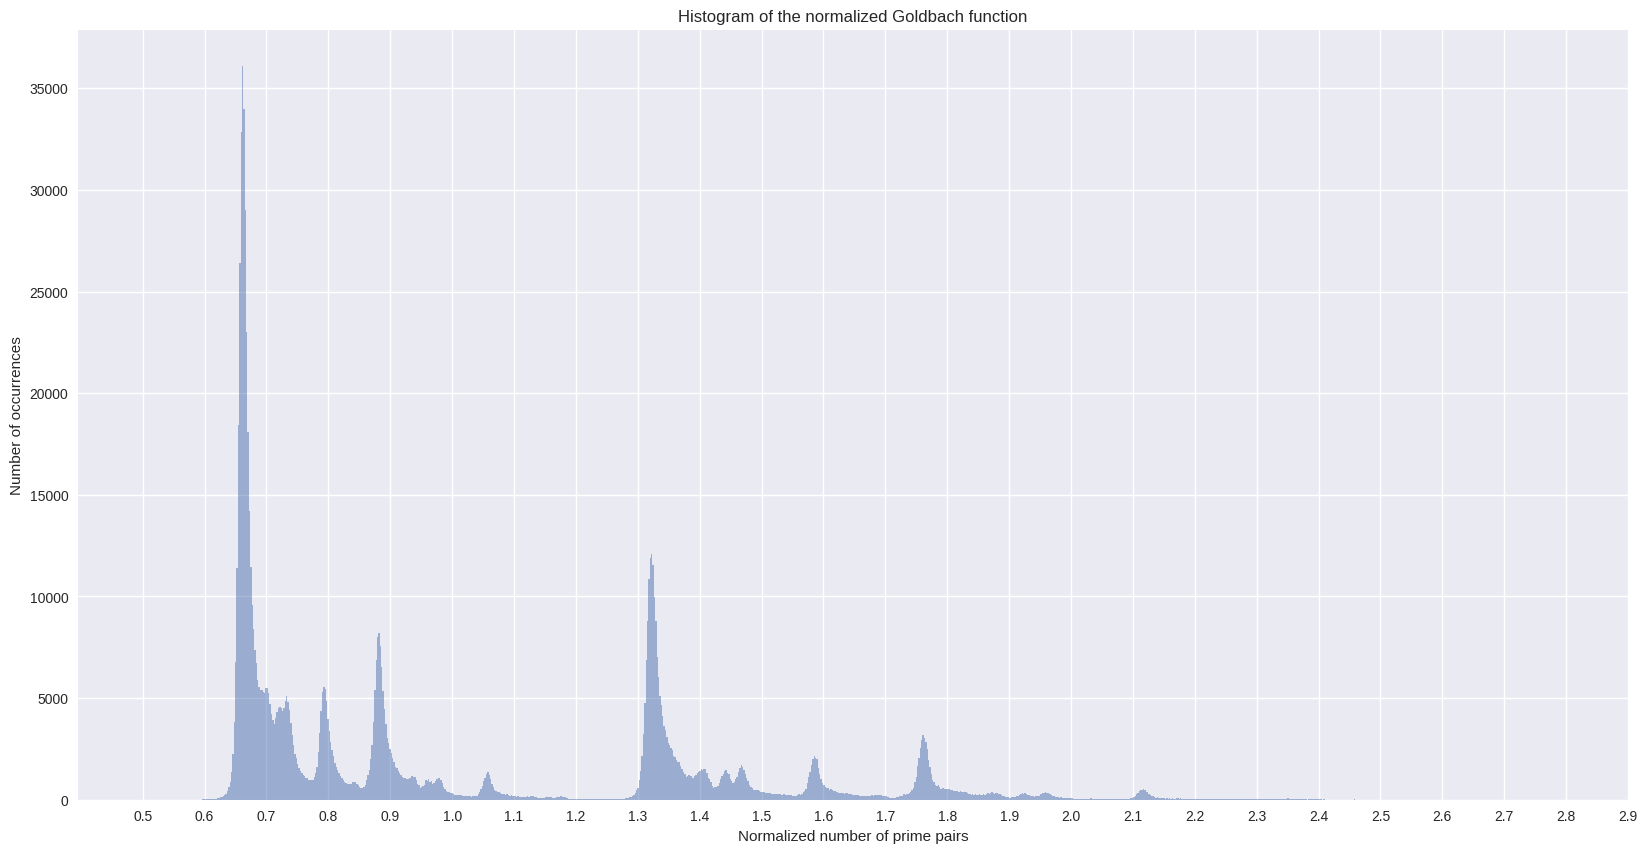

In [17]:
%%time
ax = g_df["g_norm"].hist(bins=1000, alpha=0.5, figsize=FS)
ax.grid(True)
_ = ax.set(
    title="Histogram of the normalized Goldbach function",
    xlabel="Normalized number of prime pairs",
    ylabel="Number of occurrences",
)
_ = plt.xticks(np.arange(0.5, 3.0, 0.1))

## The Hardy-Littlewood estimate

As described on the [Wikipedia page](https://en.wikipedia.org/wiki/Goldbach%27s_comet) for Goldbach's comet, the number of Goldbach partitions can be estimated using the following formulae from Hardy and Littlewood (1922) :

$$\frac{g(E)}{g_{av}} \approx c \prod_{F(E/2)} \frac{p-1}{p-2}$$

where the product is taken over $F(E/2)$ : all primes p that are factors of $E/2$. The constant $c$ is the twin primes constant :

$$c = \prod_{p \geq 3} \left( 1 - \frac{1}{(1-p)^2} \right)$$

where the product is taken over all primes larger or equal to 3.

In [18]:
%%time
primes = np.array([i for i in sieve.primerange(n)])
c = np.prod(1.0 - 1.0 / np.power(1.0 - primes[1:], 2))
c

CPU times: user 43.6 ms, sys: 0 ns, total: 43.6 ms
Wall time: 42.9 ms


0.6601618372035142

So let's compute this estimate of the normalized Goldbach function with Numba `njit` :

In [19]:
@njit(parallel=True)
def compute_g_hl_vector(primes: np.ndarray, n_max: int, c: float) -> np.ndarray:

    n_max_half = int(0.5 * n_max) + 1

    g_hl_vec = np.empty(n_max_half, dtype=np.float64)

    for E_half in prange(n_max_half):
        i_max = np.searchsorted(primes, E_half, side="right")
        prod = 1.0
        for i in range(1, i_max):
            p = primes[i]
            if E_half % p == 0:  # if p is a factor of E/2
                prod *= (p - 1.0) / (p - 2.0)

        g_hl_vec[E_half] = np.float64(prod)
    g_hl_vec *= c

    return g_hl_vec

In [20]:
%%time
g_hl_vec = compute_g_hl_vector(primes, n, c)

CPU times: user 2min 28s, sys: 24 ms, total: 2min 28s
Wall time: 1min 49s


In [21]:
g_hl_df = pd.DataFrame(data={"E": 2 * np.arange(len(g_hl_vec)), "g_norm": g_hl_vec})

CPU times: user 18.7 ms, sys: 7.98 ms, total: 26.7 ms
Wall time: 26.7 ms


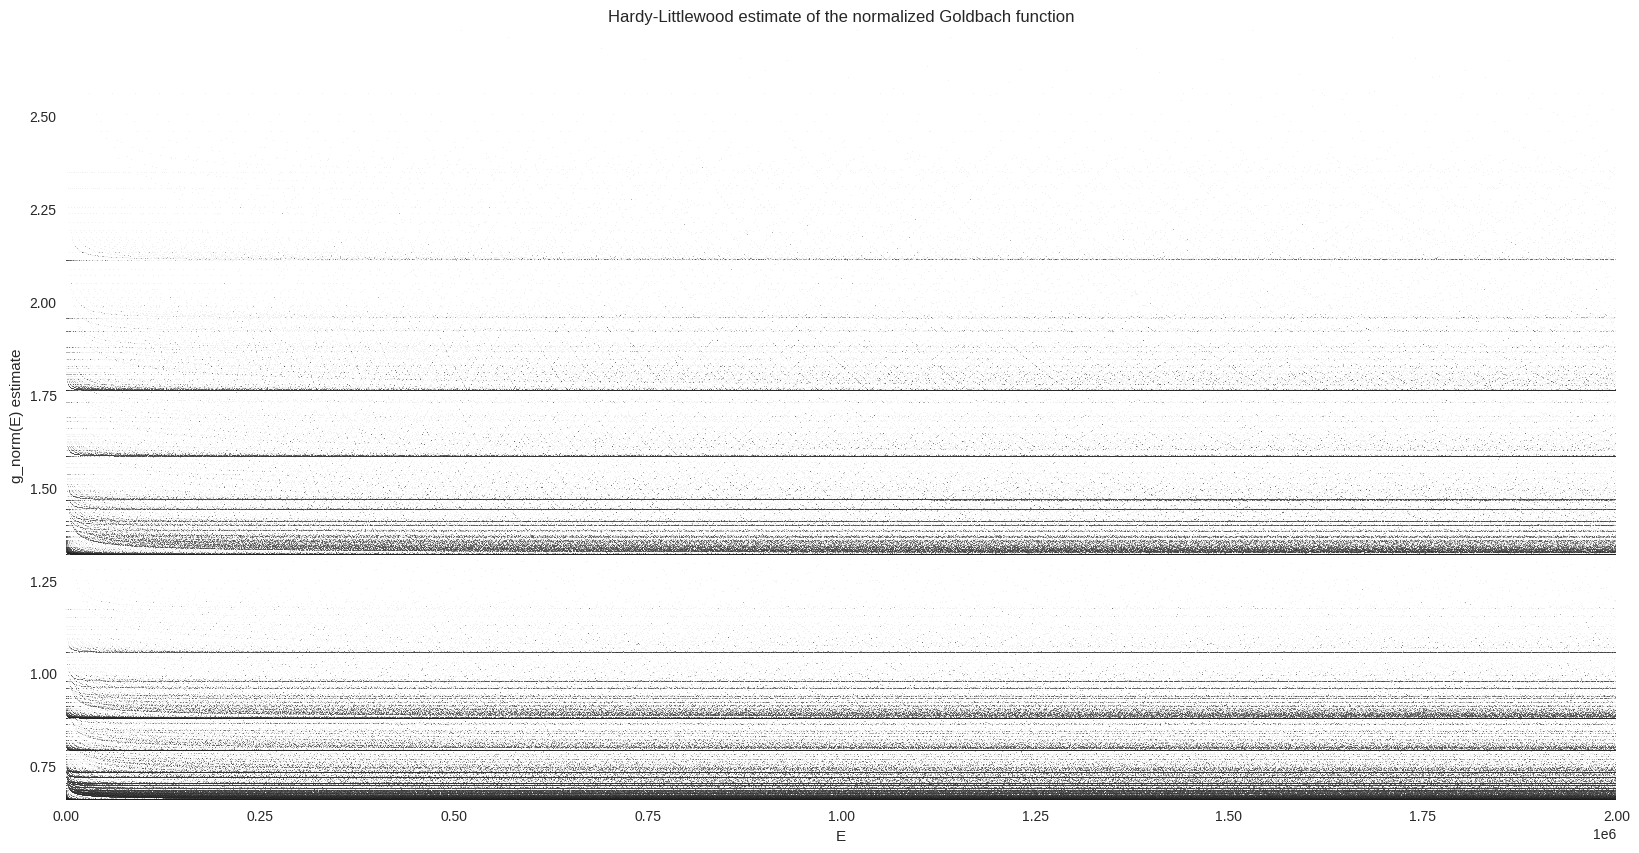

In [22]:
%%time
fig, ax = plt.subplots(figsize=FS)
_ = dsshow(
    g_hl_df,
    ds.Point("E", "g_norm"),
    norm="eq_hist",
    cmap=cmap,
    aspect="auto",
    ax=ax,
)
ax.grid(False)
ax.set_facecolor(bg_col)
_ = ax.set(title="Hardy-Littlewood estimate of the normalized Goldbach function", xlabel="E", ylabel="g_norm(E) estimate")

The vertical distribution of the dense lines seems to be similar to the one from the normalized Goldbach function. This can be checked by computing and plotting both kernel density estimates.

CPU times: user 30 s, sys: 84 ms, total: 30.1 s
Wall time: 29.7 s


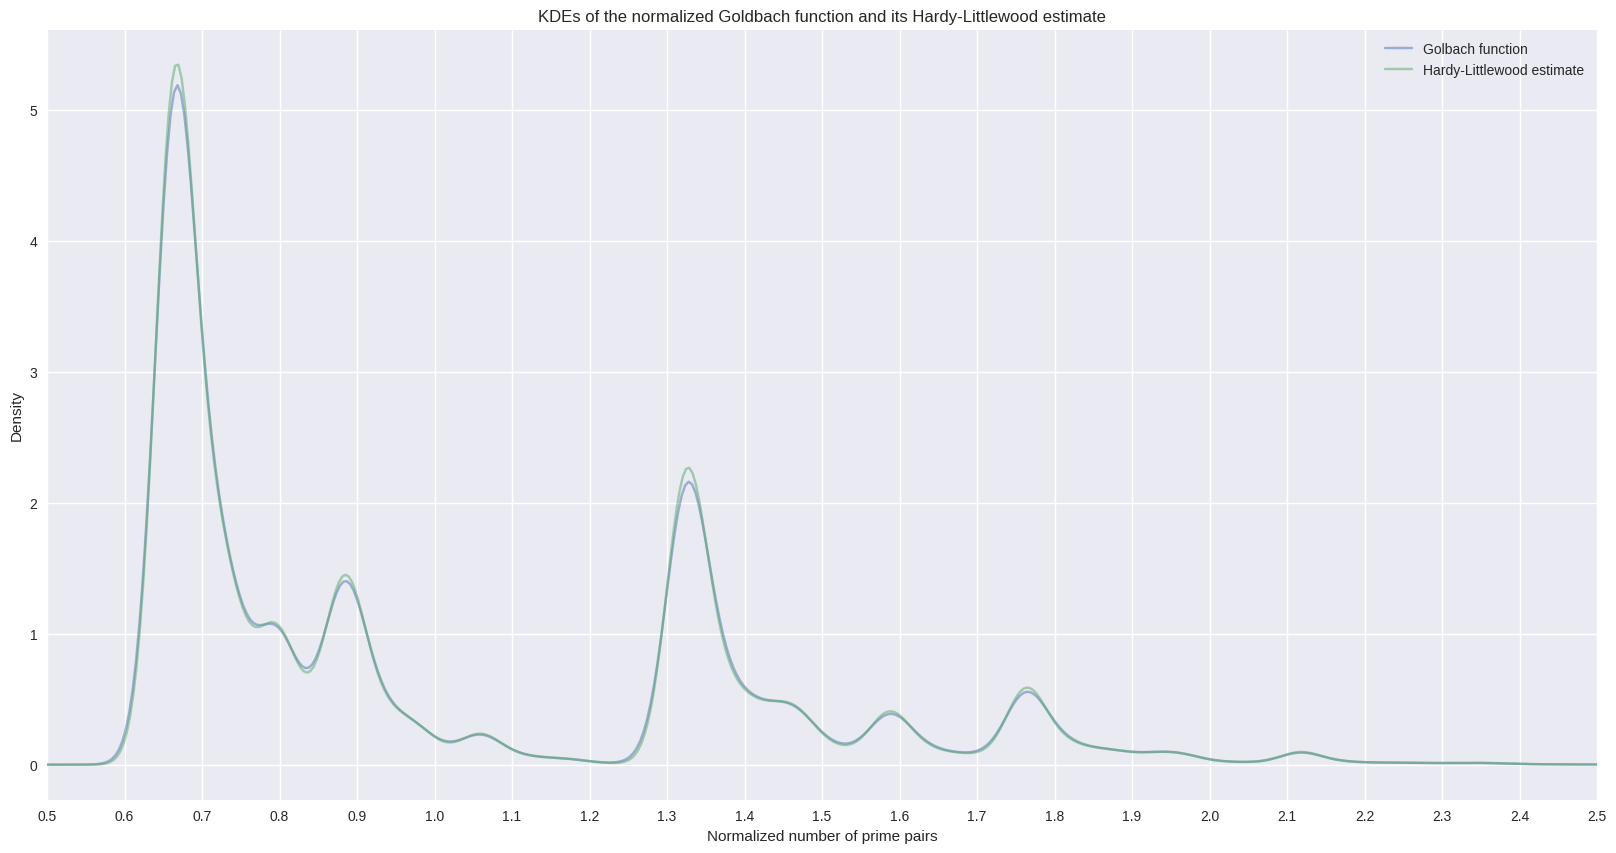

In [23]:
%%time
ax = g_df["g_norm"].plot.density(alpha=0.5, figsize=FS, label='Golbach function')
ax = g_hl_df.g_norm.plot.density(alpha=0.5, ax=ax, label='Hardy-Littlewood estimate')
ax.grid(True)
_ = ax.set(
    title="KDEs of the normalized Goldbach function and its Hardy-Littlewood estimate",
    xlabel="Normalized number of prime pairs",
    ylabel="Density",
)
_ = ax.legend()
_ = plt.xticks(np.arange(0.5, 3.0, 0.1))
_ = ax.set_xlim(0.5, 2.5)

## Prime E/2 values only

Finally, we are going to isolate a part of the most dense line from the comet tail (for a normalized number of prime pairs around 0.66). As explained on [Wikipedia](https://en.wikipedia.org/wiki/Goldbach%27s_comet):
    
> Of particular interest is the peak formed by selecting only values of $E/2$ that are prime. [...] The peak is very close to a Gaussian form. 

In [24]:
g_df["E_half"] = (0.5 * g_df["E"]).astype(int)
g_df_primes = g_df[g_df["E_half"].isin(primes)]

CPU times: user 15.4 ms, sys: 4 ms, total: 19.4 ms
Wall time: 18.8 ms


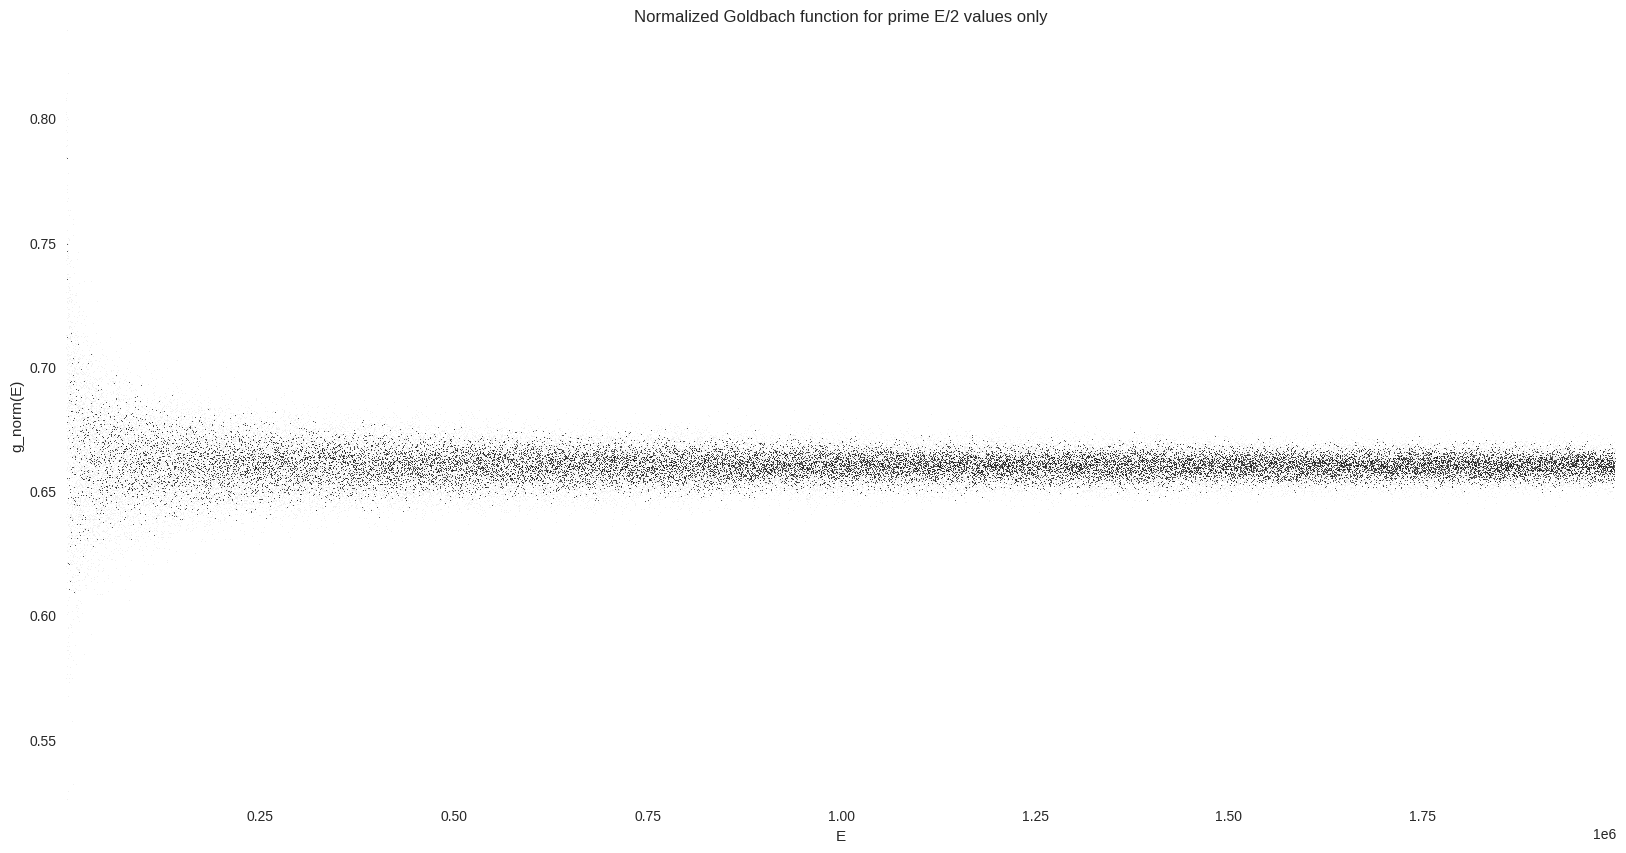

In [25]:
%%time
fig, ax = plt.subplots(figsize=FS)
_ = dsshow(
    g_df_primes,
    ds.Point("E", "g_norm"),
    norm="eq_hist",
    cmap=cmap,
    aspect="auto",
    ax=ax,
)
ax.grid(False)
ax.set_facecolor(bg_col)
_ = ax.set(title="Normalized Goldbach function for prime E/2 values only", xlabel="E", ylabel="g_norm(E)")

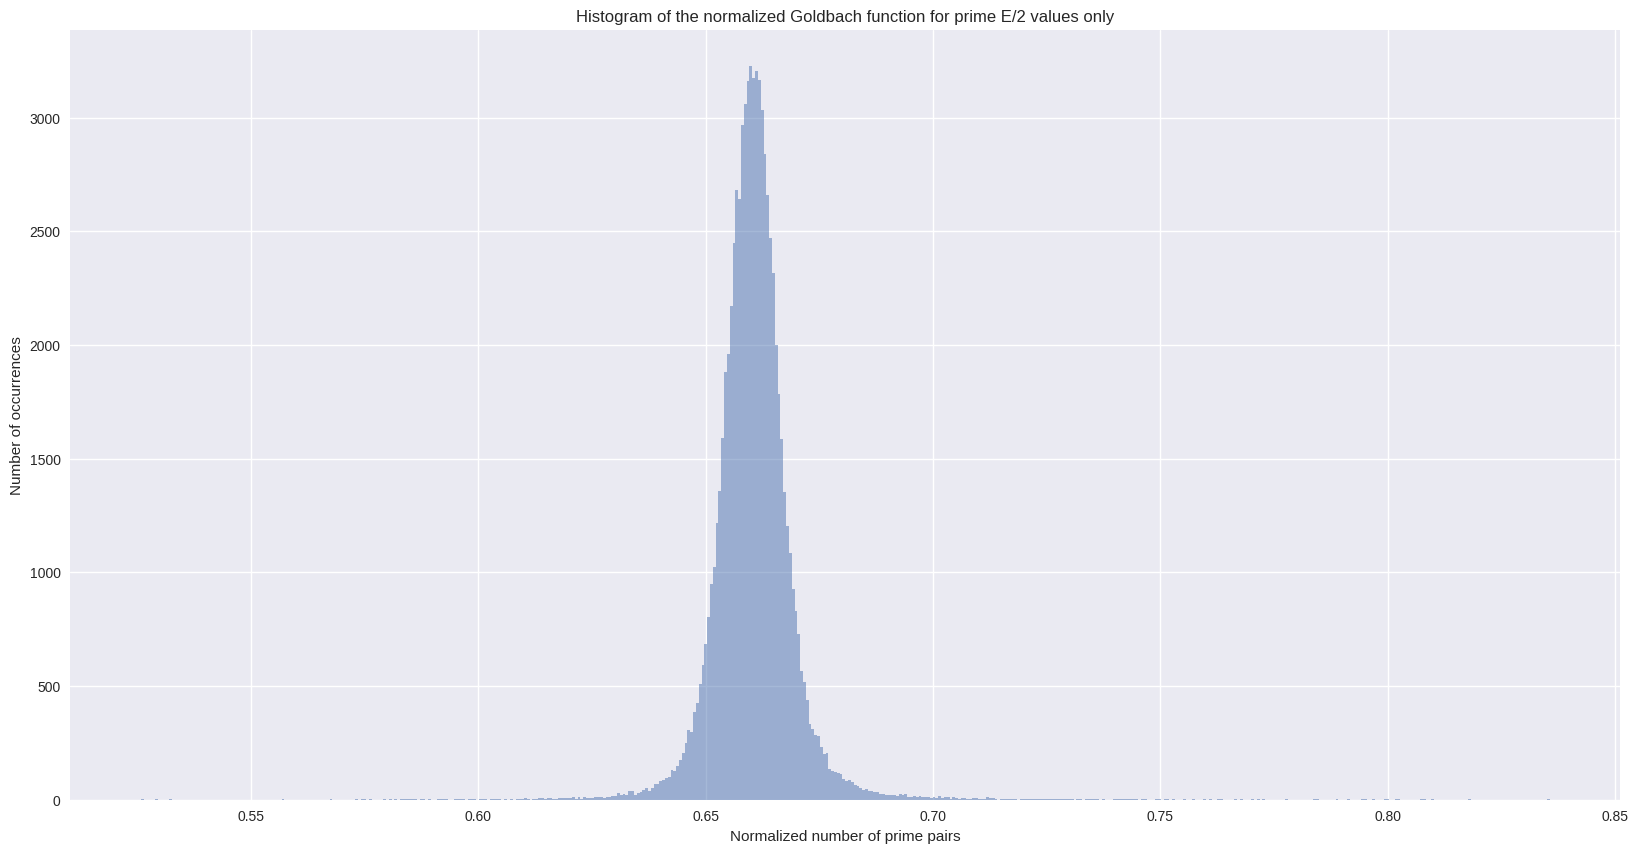

In [26]:
ax = g_df_primes["g_norm"].hist(bins=500, alpha=0.5, figsize=FS)
ax.grid(True)
_ = ax.set(
    title="Histogram of the normalized Goldbach function for prime E/2 values only",
    xlabel="Normalized number of prime pairs",
    ylabel="Number of occurrences",
)

## Conclusion

As is often the case with number theory, it appears that the computation of Goldbach function is quite expensive. But we saw that speeding up these CPU bound processes using Numba is straightforward, as well as it is to quickly plot a dataset with a large number of points with Datashader. I am not familiar with this branch of mathematics, and with this kind of new subject, I am amazed how easy it is to launch a notebook, play with these formulas and visualize the data in Python.